# "Smart" Gesture Recognition


**Business Proposal**

Nowadays, technology has a pivotal role in creating virtual environments with virtual elements. We work collaboratively with real-world intelligent objects on a day-to-day basis. Innovations like the Internet of things (IoT) products, gesture recognition, and teleportation application have certainly made our life "smarter" and more accessible.   


Embracing an "implementing a smarter life" mindset, Team College aims to develop a cool feature in the smart TV that can recognize five different gestures performed by the user to help users control the TV without using a remote. Based on this dataset, Team College wants to develop a well-rounded deep learning gesture recognition model which has applications in a spectrum of different industries beyond smart-TV. 

**Dataset Description**
The data consists of a few hundred videos categorized into five classes: thumb up, thumb down, swipe left, swipe right, stop. The webcam mounted on the TV continuously monitors the gestures. Each motion corresponds to a specific command:    
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

The training data consists of 19,890 images (663*30): there are 663 videos categorized into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). The testing data consists of a total of 3,000 images.	  

Various people have recorded these videos performing one of the five gestures in front of a webcam - like what the smart TV will use. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos) 

### Team College Objectives:
1. **Data Preprocessing_Generator Establishment**:  Team College aim to build a function called "Generator" so that this fuction should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Experimentation _ Model Architecture**: Team College aim to develop the best model that is able to train with high accuracy and without any errors. To achieve the goal, Conv3D with Maxpolling 3D, RNN, CNN LSTM with GRU (for augmentation) models will be used to tackle the problem. 

3. **Best Performing Model**: Further Development and Tryouts such as Generative Adversarial Networks (GAN) , Different Batch Size, Learning Rate and tansfer learning method will be applied to design the best performing Model.

## Housekeeping Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from matplotlib import image
import numpy as np

import os
from skimage.transform import resize
from imageio import imread
import datetime

import pathlib
from os.path import isfile, join

import matplotlib.pyplot as plt
import PIL
import PIL.Image
import warnings
warnings.filterwarnings('ignore')

We set the random seed as 30 to ensure the steady outcome

In [2]:
import datetime
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(30)

import torch
import torch.nn as nn

Setp for GPU check, if you have it, lucky you; ifelse, this might take some time to compute :)

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Test for read one image

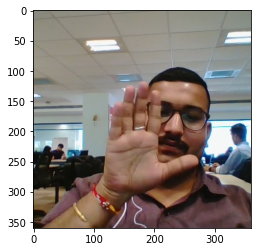

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

img = imread("Project_data/train/WIN_20180907_15_44_55_Pro_Stop Gesture_new/WIN_20180907_15_44_55_Pro_00028.png")
plt.imshow(img)

### Convert the image to grayscale because threshold otsu works only on 2 dimentional image

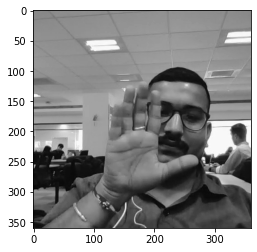

In [7]:
# convert the image to grayscale
gray_img = rgb2gray(img)
plt.imshow(gray_img, cmap="gray")

In [9]:
def threshold_otsu_impl(image, nbins=0.1):
    
    #validate grayscale
    if len(image.shape) == 1 or len(image.shape) > 2:
        print("must be a grayscale image.")
        return
    
    #validate multicolored
    if np.min(image) == np.max(image):
        print("the image must have multiple colors")
        return
    
    all_colors = image.flatten()
    total_weight = len(all_colors)
    least_variance = -1
    least_variance_threshold = -1
    
    # create an array of all possible threshold values which we want to loop through
    color_thresholds = np.arange(np.min(image)+nbins, np.max(image)-nbins, nbins)
    
    # loop through the thresholds to find the one with the least within class variance
    for color_threshold in color_thresholds:
        bg_pixels = all_colors[all_colors < color_threshold]
        weight_bg = len(bg_pixels) / total_weight
        variance_bg = np.var(bg_pixels)

        fg_pixels = all_colors[all_colors >= color_threshold]
        weight_fg = len(fg_pixels) / total_weight
        variance_fg = np.var(fg_pixels)

        within_class_variance = weight_fg*variance_fg + weight_bg*variance_bg
        if least_variance == -1 or least_variance > within_class_variance:
            least_variance = within_class_variance
            least_variance_threshold = color_threshold
            print("trace:", within_class_variance, color_threshold)
            
    return least_variance_threshold

trace: 0.029267757473489274 0.10333333333333333
trace: 0.02096824723702627 0.20333333333333334
trace: 0.014221426264815267 0.30333333333333334
trace: 0.012012430290705804 0.4033333333333334
trace: 0.029267757473489274 0.10333333333333333
trace: 0.02096824723702627 0.20333333333333334
trace: 0.014221426264815267 0.30333333333333334
trace: 0.012012430290705804 0.4033333333333334


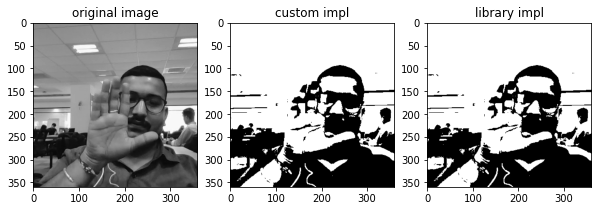

In [10]:
from skimage.filters import threshold_otsu

# thresholding the image using our custom implementation
threshold_c = threshold_otsu_impl(gray_img)
bin_img_from_custom = gray_img > threshold_c

# thresholding the image using the skimage library implementation
threshold_s = threshold_otsu_impl(gray_img)
bin_img_from_lib = gray_img > threshold_s

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].set_title("original image")
ax[0].imshow(gray_img, cmap="gray")

ax[1].set_title("custom impl")
ax[1].imshow(bin_img_from_custom, cmap="gray")

ax[2].set_title("library impl")
ax[2].imshow(bin_img_from_lib, cmap="gray")

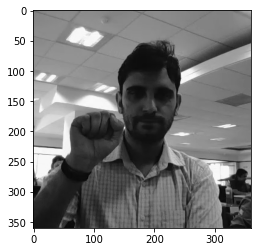

In [14]:
img2 = imread("Project_data/train/WIN_20180907_15_49_58_Pro_Stop Gesture_new/WIN_20180907_15_49_58_Pro_00032.png")
plt.imshow(img2)

# convert the image to grayscale
gray_img2 = rgb2gray(img2)
plt.imshow(gray_img2, cmap="gray")

trace: 0.03794869262020124 0.10448705882352942
trace: 0.02413263314647844 0.2044870588235294
trace: 0.01658727586762596 0.3044870588235294
trace: 0.015320942308633151 0.4044870588235294
trace: 0.03794869262020124 0.10448705882352942
trace: 0.02413263314647844 0.2044870588235294
trace: 0.01658727586762596 0.3044870588235294
trace: 0.015320942308633151 0.4044870588235294


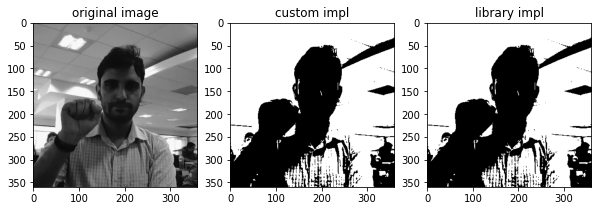

In [15]:
from skimage.filters import threshold_otsu

# thresholding the image using our custom implementation
threshold_c = threshold_otsu_impl(gray_img2)
bin_img_from_custom = gray_img2 > threshold_c

# thresholding the image using the skimage library implementation
threshold_s = threshold_otsu_impl(gray_img2)
bin_img_from_lib = gray_img2 > threshold_s

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].set_title("original image")
ax[0].imshow(gray_img2, cmap="gray")

ax[1].set_title("custom impl")
ax[1].imshow(bin_img_from_custom, cmap="gray")

ax[2].set_title("library impl")
ax[2].imshow(bin_img_from_lib, cmap="gray")

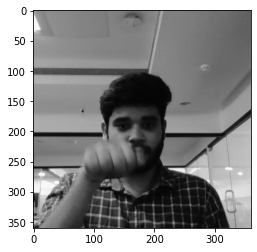

In [17]:
img3 = imread("Project_data/train/WIN_20180907_15_43_40_Pro_Stop Gesture_new/WIN_20180907_15_43_40_Pro_00017.png")
plt.imshow(img3)

# convert the image to grayscale
gray_img3 = rgb2gray(img3)
plt.imshow(gray_img3, cmap="gray")

trace: 0.022953469874924422 0.12920784313725492
trace: 0.014285342139082596 0.22920784313725492
trace: 0.01101696095888685 0.32920784313725493
trace: 0.022953469874924422 0.12920784313725492
trace: 0.014285342139082596 0.22920784313725492
trace: 0.01101696095888685 0.32920784313725493


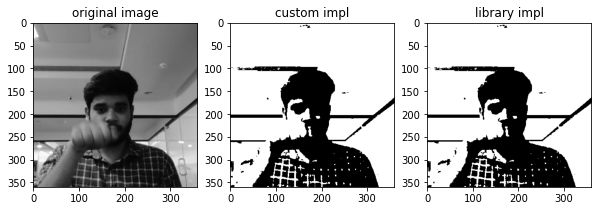

In [20]:
from skimage.filters import threshold_otsu

# thresholding the image using our custom implementation
threshold_c = threshold_otsu_impl(gray_img3)
bin_img_from_custom = gray_img3> threshold_c

# thresholding the image using the skimage library implementation
threshold_s = threshold_otsu_impl(gray_img3)
bin_img_from_lib = gray_img3 > threshold_s

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].set_title("original image")
ax[0].imshow(gray_img3, cmap="gray")

ax[1].set_title("custom impl")
ax[1].imshow(bin_img_from_custom, cmap="gray")

ax[2].set_title("library impl")
ax[2].imshow(bin_img_from_lib, cmap="gray")

## Load Data

- No. training sequences = 530
- No. validation sequences = 133
- No. testing sequences = 100

train-val-test = 70% - 17% -13%

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
test_doc = np.random.permutation(open('Project_data/test.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 64

## Data EDA
Sample train and val dataset display as follow:
- train_doc contains 662 datapoints
- val-doc contains 100 datapoints

In [5]:
train_doc

array(['WIN_20180926_17_13_13_Pro_Right_Swipe_new,Right_Swipe_new,1\n',
       'WIN_20180925_18_08_08_Pro_Thumbs_Up_new,Thumbs_Up_new,4\n',
       'WIN_20180907_16_12_09_Pro_Stop Gesture_new,Stop Gesture_new,2\n',
       'WIN_20180926_17_23_39_Pro_Left_Swipe_new,Left_Swipe_new,0\n',
       'WIN_20180926_17_12_26_Pro_Stop_new,Stop_new,2\n',
       'WIN_20180926_17_08_38_Pro_Thumbs_Down_new,Thumbs_Down_new,3\n',
       'WIN_20180926_17_22_16_Pro_Thumbs_Up_new,Thumbs_Up_new,4\n',
       'WIN_20180925_18_14_35_Pro_Right_Swipe_new,Right_Swipe_new,1\n',
       'WIN_20180925_17_57_36_Pro_Left_Swipe_new,Left_Swipe_new,0\n',
       'WIN_20180926_17_05_32_Pro_Stop_new,Stop_new,2\n',
       'WIN_20180907_16_25_10_Pro_Thumbs Up_new,Thumbs Up_new,4\n',
       'WIN_20180926_17_47_31_Pro_Thumbs_Down_new,Thumbs_Down_new,3\n',
       'WIN_20180925_17_42_12_Pro_Right_Swipe_new,Right_Swipe_new,1\n',
       'WIN_20180925_17_46_33_Pro_Thumbs_Down_new,Thumbs_Down_new,3\n',
       'WIN_20180926_17_24_33_Pro_

In [6]:
val_doc

array(['WIN_20180925_17_46_05_Pro_Stop_new,Stop_new,2\n',
       'WIN_20180907_16_14_43_Pro_Thumbs Down_new,Thumbs Down_new,3\n',
       'WIN_20180907_16_07_50_Pro_Thumbs Down_new,Thumbs Down_new,3\n',
       'WIN_20180907_16_28_15_Pro_Stop Gesture_new,Stop Gesture_new,2\n',
       'WIN_20180907_16_41_13_Pro_Thumbs Down_new,Thumbs Down_new,3\n',
       'WIN_20180926_16_40_38_Pro_Right_Swipe_new,Right_Swipe_new,1\n',
       'WIN_20180926_16_58_27_Pro_Right_Swipe_new,Right_Swipe_new,1\n',
       'WIN_20180925_17_57_58_Pro_Right_Swipe_new,Right_Swipe_new,1\n',
       'WIN_20180907_16_53_36_Pro_Thumbs Down_new,Thumbs Down_new,3\n',
       'WIN_20180907_16_37_03_Pro_Right Swipe_new,Right Swipe_new,1\n',
       'WIN_20180925_17_52_58_Pro_Left_Swipe_new,Left_Swipe_new,0\n',
       'WIN_20180907_16_32_17_Pro_Left Swipe_new_Left Swipe_new,Left Swipe_new_Left Swipe_new,0\n',
       'WIN_20180925_17_49_29_Pro_Left_Swipe_new,Left_Swipe_new,0\n',
       'WIN_20180925_18_06_22_Pro_Left_Swipe_new,Lef

In [7]:
test_doc

array(['WIN_20180926_17_05_38_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_58_08_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180907_16_29_12_Pro_Thumbs Down_new;Thumbs Down_new;3\n',
       'WIN_20180926_17_21_48_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180907_15_38_42_Pro_Thumbs Up_new;Thumbs Up_new;4\n',
       'WIN_20180925_17_52_42_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180926_17_15_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180926_17_33_49_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180926_16_52_49_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180907_16_18_23_Pro_Thumbs Down_new;Thumbs Down_new;3\n',
       'WIN_20180926_16_47_44_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180926_17_09_33_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180926_16_47_09_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180926_17_29_34_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180926_17_35_34_Pro_Right_Swipe_new;Ri

## Data Preprocessing 
Following steps are followed:
1. Resized the image and cropped smaller image shape at center for 120*120
2. Normalized Images
3. Built 3D and 2D filter function 
4. Established function to get batch data for preprocessing Convo3D

In [8]:
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [9]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [10]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [11]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

### For Windows User Only

In [12]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

### For Mac User Only

In [13]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(',')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(',')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(',')[2])] = 1
    return batch_data, batch_labels

## Generator Establishment
Since the dataset contains 2 types of dimensions, a "generator" is build to preprocess the images for `2D` and `3D` dimensions, as well as create `a batch of video frames`. We experiment with `img_idx`, `y`,`z` and normalization such that to achieve a high accuracy outcome.

In [14]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

Note: a video is represented above in the generator as (number of images, height, width, number of channels)

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
test_path = './Project_data/test'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_test_sequences = len(test_doc)
print('# Test sequences =', num_test_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 530
# validation sequences = 133
# Test sequences = 100
# epochs = 10


In [16]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


### Generator Validation

In [17]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  ./Project_data/train ; batch size = 64
(64, 20, 100, 100, 3)
Source path =  ./Project_data/val ; batch size = 64
(64, 20, 100, 100, 3)


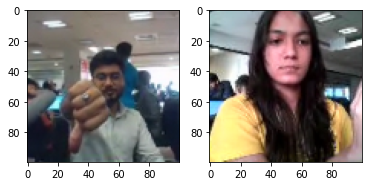

In [18]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[15,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[5,10,:,:,:])
plt.show()

In [19]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

## Model Building
Team College aim to develop the best model that is able to train with high accuracy and without any errors. To achieve the goal, following Models have been used for tryouts:

1. `Conv3D` with `MaxPooling3D` for a 3D convolution model 
2. `TimeDistributed` while building a Conv2D + RNN model
3. `CNN LSTM with GRU` for augmentation

Moreover, for each model, we set the last layer is the softmax so that the least number of parameters can fit in the memory of the webcam. Hence to perform a good accuracy on the least number of parameters.

In [20]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

### Base Model

In [21]:
#write your model here
def defineModel(img_tensor):
    
    opt = tf.keras.optimizers.Adam()
    
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Metal device set to: AMD Radeon Pro 5500M


2022-03-03 18:04:11.599168: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 18:04:11.600046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-03 18:04:11.600295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 48, 48, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 48, 48, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 23, 23, 32)    0         
 3D)                                                             
                                                        

In [22]:
#write your model here
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])
    
    opt = tf.keras.optimizers.Adam()

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 8, 48, 48, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 8, 48, 48, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 6, 23, 23, 32)    0         
 3D)                                                             
                                                      

In [23]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Model Callbacks Setup1 _ CheckPoint Callback -- Need further develpoment
you can try one of the callbasks for now

In [25]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_fre='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

### Model Callbacks Setup2 _ Tensorboard Callback

In [26]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint2 = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=0, write_graph=True,write_images=False, write_steps_per_second=False, update_freq='epoch',
    profile_batch=0, embeddings_freq=0, embeddings_metadata=None)

LR2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint2, LR2]
callbacks_list = [LR2]

### Model Callbacks Setup3 _ EarlyStop Callback

In [27]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint3 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0, verbose=1,mode='auto', baseline=None, restore_best_weights=False)

LR3 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint3, LR3]
callbacks_list = [LR3]

### Test Batch Size & Frames

In [28]:
def testBatchSize(batch_size, n_frames):
    img_tensor = getImgTensor(n_frames)
    print("Using frames as", img_tensor[0])
    global callbacks_list
    num_epochs = 3
    train_generator = generator(train_path, train_doc, batch_size, img_tensor)
    val_generator = generator(val_path, val_doc, batch_size, img_tensor)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model = defineModel(img_tensor)
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
testBatchSize(batch_size=64, n_frames=30)

Using frames as [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Source path =  ./Project_data/train ; batch size = 64
Epoch 1/3


2022-03-03 18:04:27.552458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-03 18:04:27.753 python[32812:873879] -[MPSGraph adamUpdateWithLearningRateTensor:beta1Tensor:beta2Tensor:epsilonTensor:beta1PowerTensor:beta2PowerTensor:valuesTensor:momentumTensor:velocityTensor:gradientTensor:name:]: unrecognized selector sent to instance 0x60000b2ff480


In [ ]:
testBatchSize(batch_size=64, n_frames=16)

In [ ]:
testBatchSize(batch_size=32, n_frames=30)

In [ ]:
testBatchSize(batch_size=32, n_frames=16)

With above observations, we can see that batch size is not impacting training time but number of frames. We will use batch size of 64 as it seems optimal. It is commented as it takes a lot of time to run that is restricting for the notebook to completely run.

### Model 1 - Frames-16, Epoc-20

In [ ]:
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model1.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plotModelHistory(model1_history)

### Model 2: Playground for whatever model you would like to try